In [1]:
import sys
sys.path.append('..')
from pdetools import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
%matplotlib notebook

## Exploring D vs koff parameter space

This notebook demonstrates code for performing D vs koff parameter space analysis on the model presented in notebook 1

### ParamSpace2D

This pdetools package contains a class that can be used for performing 2D parameter space analysis on any model.

```python
ParamSpace2D(func, p1_range, p2_range, resolution, direc, parallel=False, cores=None, args=[], replace=False)
```

The class takes the following arguments:
- func: Function to evaluate. Must take two parameter values as inputs, and return a single number representing a measure of model behaviour. This can be a float, in the case of a quantitative measure (e.g. asymmetry index, aPAR domain size), or an integer in the case of a quantitative measure (e.g. 0/1 = polarised/not polarised).
- p1_range: (lower, upper) bounds for parameter 1 (first argument to func)
- p2_range: (lower, upper) bounds for parameter 2 (second argument to func)
- resolution: parameter grid resolution
- direc: directory to save results. If it doesn't already exist it will be created
- parallel: if True, will perform computations in parallel using python multitasking package
- cores: number of cores to use if parallel=True. If None, will use all available cores.
- args: optional additional arguments for func
- replace: If True, any results already stored in direc will be deleted and replaced. If False, any results already stored in direc will be imported and not replaced.

Parameter sweeps can be run by calling the run function.

Below, I will outline how to perform parameter space analysis on the model outlined in notebook 1

### Model code

Repeating the core model code here (fully outlined in notebook 1)

In [2]:
def generate_flow_profile(A=74, B=391, C=1000, D=100):
    X = np.linspace(0, 60, 100)
    v = (((60-X) / A) * np.exp(-((60-X) ** 2) / B)) - ((X / C) * np.exp(-(X ** 2) / D))
    return v

class Model:
    def __init__(self, D, kon, koff, psi=0.174, tot=1.56):

        # Diffusion
        self.D = D # diffusion coefficient

        # Flow profile
        self.flow_profile = generate_flow_profile()

        # Membrane exchange
        self.kon = kon # membrane binding rate
        self.koff = koff # membrane unbinding rate

        # Misc
        self.tot = tot # total amount of protein
        self.psi = psi # surface area to volume ratio
        self.xsteps = 100 # number of positions to split the spatial dimension into
        self.L = 60 # system length
        self.deltax = self.L / self.xsteps # spatial step

    def diffusion(self, concs, dx):
        concs_ = np.r_[concs[0], concs, concs[-1]] # Dirichlet boundary conditions
        d = concs_[:-2] - 2 * concs_[1:-1] + concs_[2:]
        return d / (dx ** 2)

    def flow(self, concs, dx):
        # Calculates the gradient in both directions and takes the average
        return (np.r_[0, np.diff(concs * self.flow_profile)] +
                  np.r_[np.diff(concs * self.flow_profile), 0]) / (2 * dx)

    def dxdt(self, X):
        m = X[0]
        c = self.tot - self.psi * np.mean(m) # calculate uniform cytoplasmic concentration
        flow = self.flow(m, self.deltax)
        dm = (self.kon * c) - (self.koff * m) + (self.D * self.diffusion(m, self.deltax)) + flow
        return [dm, ]

    def dxdt_no_flow(self, X):
        m = X[0]
        c = self.tot - self.psi * np.mean(m) # calculate uniform cytoplasmic concentration
        dm = (self.kon * c) - (self.koff * m) + (self.D * self.diffusion(m, self.deltax))
        return [dm, ]

    def run(self, Tmax, t_eval=None, start=None, flow=True, killfunc=None, maxstep=None, rk=True):

        # Specify evaluation times
        if t_eval is None:
            t_eval = np.arange(0, Tmax + 0.0001, Tmax)

        # Specify starting conditions
        if start is None:
            # Start from uniform equilibrium membrane concentration, calculated analytically
            start = (self.kon * self.tot) / (self.koff + self.psi * self.kon)
            start *= np.ones([self.xsteps])

        # Specify flow regime
        if flow:
            func = self.dxdt
        else:
            func = self.dxdt_no_flow

        # Run simulation
        soln, time, solns, times = pdeRK(dxdt=func, X0=[start, ], Tmax=Tmax, deltat=0.01, t_eval=t_eval, 
                                         killfunc=killfunc, maxstep=maxstep)
        # Return results
        return soln, time, solns, times
    
def calc_asi(m):
    ant = np.mean(m[:30])
    post = np.mean(m[-30:])
    asi = abs((ant - post) / (2 * (ant + post)))
    return asi

### Figure 1: asymmetry index (ASI) as function of D and koff (log scale)

N.B. Simulations have already been run and saved results will be imported. If the replace parameter in ParamSpace2D is set to True, saved results will be overwritten and simulations will be re-run. This will take several minutes.

#### Set up ParamSpace2D class

In [3]:
# Create function for ParamSpace2D
def func_asi(log_D, log_koff):

    # Parameters
    D = 10 ** log_D
    koff = 10 ** log_koff
    
    # Initiate model
    m = Model(D=D, koff=koff, kon=koff)

    # Run
    soln, _, _, _ = m.run(Tmax=500)

    # ASI
    asi = calc_asi(soln[0])
    return asi

# Specify parameter ranges
p1_range = (-3, 1) # log of D
p2_range = (-4, 0) # log of koff
resolution = 11 # simulations will be performed over an n x n grid (limiting to a coarse 11x11 grid)

# Specify path to save results
save_path1 = 'ParamSpace1_D_koff_ASI'

# Set up ParamSpace2D class
paramspace1 = ParamSpace2D(func=func_asi, p1_range=p1_range, p2_range=p2_range, cores=None, resolution=resolution, 
             direc=save_path1, parallel=True, replace=False)

#### Run parameter sweep

In [4]:
paramspace1.run()

#### Import results

In [5]:
res1 = np.loadtxt(save_path1 + '/Res.txt')

#### Create figure

<IPython.core.display.Javascript object>


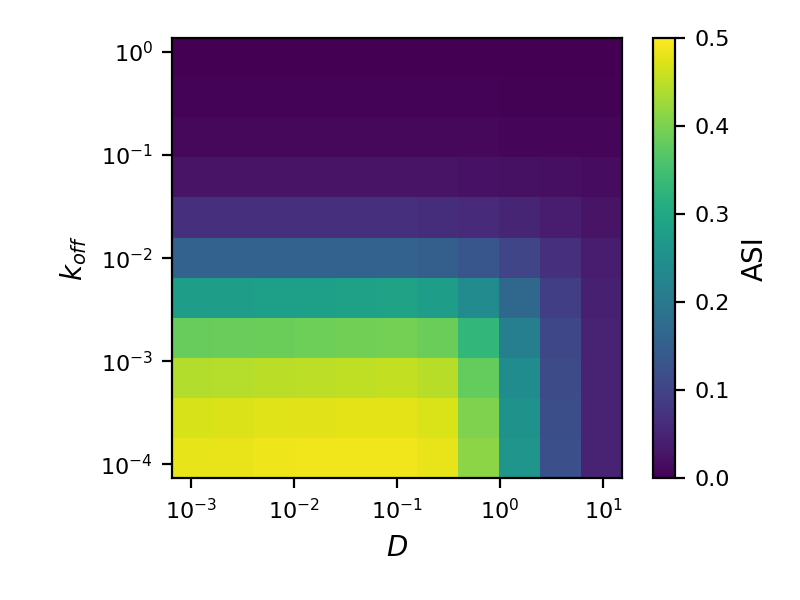

In [13]:
@plt.FuncFormatter
def fake_log(x, pos):
    'The two args are the value and tick position'
    return r'$10^{%d}$' % (x)

# Set up figure
fig, ax = plt.subplots()

# Plot data
padx = (p1_range[1] - p1_range[0]) / (2 * resolution)
pady = (p2_range[1] - p1_range[0]) / (2 * resolution)
extent = [p1_range[0] - padx, p1_range[1] + padx, p2_range[0] - pady, p2_range[1] + pady]
im = ax.imshow(res1.T, origin='lower', extent=extent, vmin=0, vmax=0.5)

# Ticks and labels
ax.set_xticks(np.arange(p1_range[0], p1_range[1] + 1))
ax.set_yticks(np.arange(p2_range[0], p2_range[1] + 1))
ax.xaxis.set_major_formatter(fake_log)
ax.yaxis.set_major_formatter(fake_log) 
ax.set_xlabel(r'$D$')
ax.set_ylabel(r'$k_{off}$') 
ax.tick_params(axis='both', labelsize=8)

# Colorbar
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=8) 
cbar.ax.set_ylabel('ASI')

# Finalise figure
fig.set_size_inches(4, 3)
fig.tight_layout()

### Figure 2: Relaxation time as function of D and koff (log scale)

#### Set up ParamSpace2D class

In [7]:
# Create function for ParamSpace2D
def func_relaxation(log_D, log_koff):

    # Parameters
    D = 10 ** log_D
    koff = 10 ** log_koff
    
    # Initiate model
    m = Model(D=D, koff=koff, kon=koff)
    
    # Run with flow
    soln, _, _, _ = m.run(Tmax=500)

    # Calculate ASI
    asi_orig = calc_asi(soln[0])

    # ASI threshold
    def killfunc(X, asi_thresh=asi_orig * 0.5):
        current_asi = calc_asi(X[0])
        if current_asi < asi_thresh:
            return True
        return False

    # Run without flow
    soln, time, _, _ = m.run(Tmax=10000, start=soln[0], flow=False, killfunc=killfunc, maxstep=0.1)
    return time

# Specify path to save results
save_path2 = 'ParamSpace2_D_koff_ASI_relaxation'

# Set up ParamSpace2D class
paramspace2 = ParamSpace2D(func=func_relaxation, p1_range=p1_range, p2_range=p2_range, cores=None, 
                           resolution=resolution, direc=save_path2, parallel=True, replace=False)  
# (using the same parameter ranges as before)

#### Run parameter sweep

In [8]:
paramspace2.run()

#### Import results

In [9]:
res2 = np.loadtxt(save_path2 + '/Res.txt')

#### Create figure

<IPython.core.display.Javascript object>


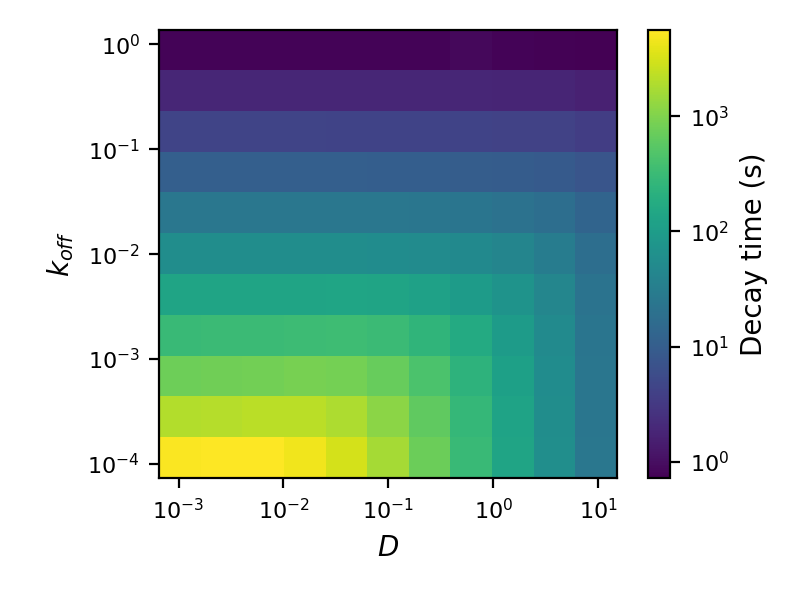

In [14]:
# Set up figure
fig, ax = plt.subplots()

# Plot data
padx = (p1_range[1] - p1_range[0]) / (2 * resolution)
pady = (p2_range[1] - p1_range[0]) / (2 * resolution)
extent = [p1_range[0] - padx, p1_range[1] + padx, p2_range[0] - pady, p2_range[1] + pady]
im = ax.imshow(np.log10(res2.T), origin='lower', extent=extent)

# Ticks and labels
ax.set_xticks(np.arange(p1_range[0], p1_range[1] + 1))
ax.set_yticks(np.arange(p2_range[0], p2_range[1] + 1))
ax.xaxis.set_major_formatter(fake_log)
ax.yaxis.set_major_formatter(fake_log) 
ax.set_xlabel(r'$D$')
ax.set_ylabel(r'$k_{off}$') 
ax.tick_params(axis='both', labelsize=8)

# Colorbar
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=8) 
cbar.ax.set_ylabel('Decay time (s)')
cbar.ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
cbar.ax.yaxis.set_major_formatter(fake_log)

# Finalise figure
fig.set_size_inches(4, 3)
fig.tight_layout()